# 5. Unsupervised Learning: Discovering Growth Strategies

This notebook uses K-Means clustering to identify distinct patterns or "strategies" of growth among the plants.
## Workflow
1.  Load the results from our **globally scaled** model fits, as these parameters are directly comparable across plants.
2.  Select key growth parameters (e.g., growth rate `r`, carrying capacity `K`) to use as features for clustering.
3.  Use the "Elbow Method" to determine the optimal number of clusters (`k`).
4.  Run the K-Means algorithm to assign each plant to a growth strategy cluster.
5.  Visualize and analyze the characteristics of the discovered clusters.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import sys
import os

# Add parent directory to path to import custom functions
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.visualization import plot_elbow_method

In [3]:
# Load the results from the GLOBAL scaling analysis
RESULTS_PATH = '../results/data/all_plant_model_results_GLOBAL.csv'
results_df = pd.read_csv(RESULTS_PATH).dropna()
print(f"Loaded GLOBAL results with shape: {results_df.shape}")

Loaded GLOBAL results with shape: (446, 26)


## Feature Selection and Scaling
We will cluster plants based on their key growth parameters. It's important to scale these features using `StandardScaler` so that parameters with larger values (like `K`) don't dominate the clustering algorithm.

In [4]:
# Select the most informative parameters that represent different aspects of growth
features_for_clustering = [
    'r_optimal_log',      # Logistic Growth Rate (how fast it grows)
    'K_optimal_log',      # Logistic Carrying Capacity (its projected max size)
    'k_optimal_linear'    # Linear Growth Rate (a simple, overall speed)
]
cluster_data = results_df[features_for_clustering]

# Scale the data so all features have equal weight
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

## Finding the Optimal Number of Clusters (Elbow Method)
We need to find the best number of clusters 'k'. The "Elbow Method" helps us do this by running K-Means for a range of `k` values and plotting the "inertia." The "elbow" of the curve (where it starts to flatten out) is a good indicator of the optimal `k`.


c:\Users\katie\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\katie\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\katie\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\katie\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

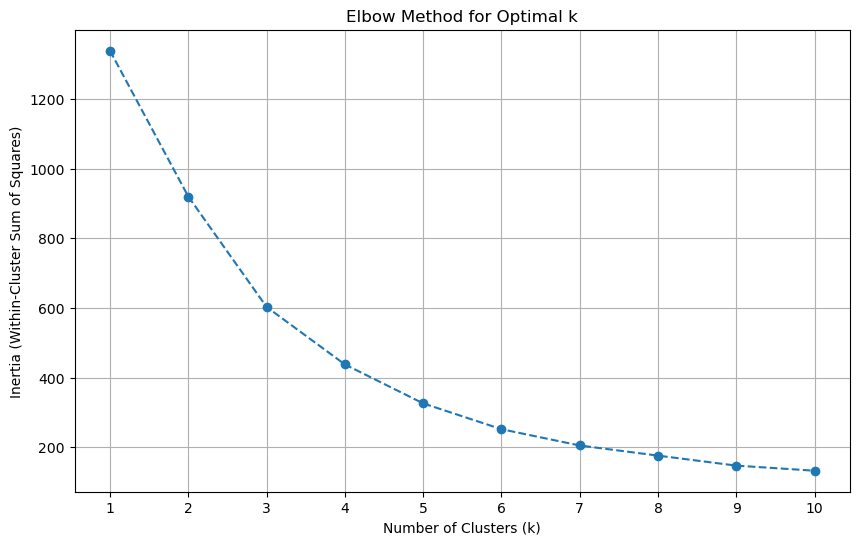

In [5]:
inertia_values = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_data_scaled)
    inertia_values.append(kmeans.inertia_)

# Use our custom plotting function
plot_elbow_method(k_range, inertia_values)


Based on the elbow plot, choose a value for `k` where the curve bends. A `k` of **3** appears to be a good choice for this dataset.
## Running K-Means and Visualizing Clusters

c:\Users\katie\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(



Assigned 446 plants to 3 clusters.


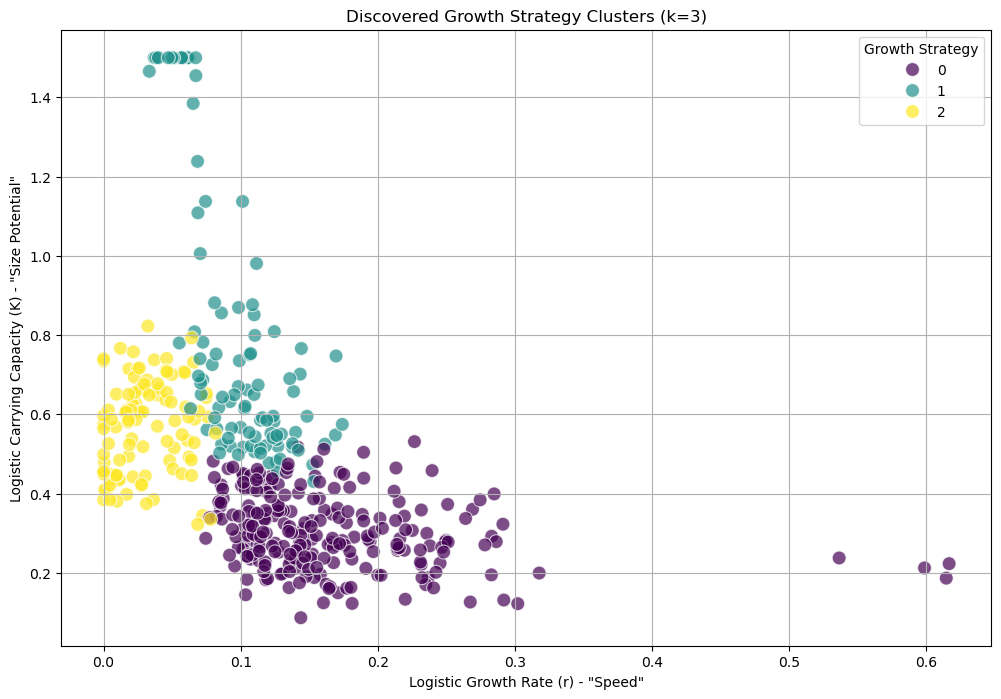

In [6]:
# Set the optimal k based on the plot above
OPTIMAL_K = 3

kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
results_df['growth_cluster'] = kmeans.fit_predict(cluster_data_scaled)

print(f"\nAssigned {len(results_df)} plants to {OPTIMAL_K} clusters.")

# Visualize the clusters using two of the most important features
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=results_df,
    x='r_optimal_log',
    y='K_optimal_log',
    hue='growth_cluster',
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title(f'Discovered Growth Strategy Clusters (k={OPTIMAL_K})')
plt.xlabel('Logistic Growth Rate (r) - "Speed"')
plt.ylabel('Logistic Carrying Capacity (K) - "Size Potential"')
plt.legend(title='Growth Strategy')
plt.grid(True)
plt.show()

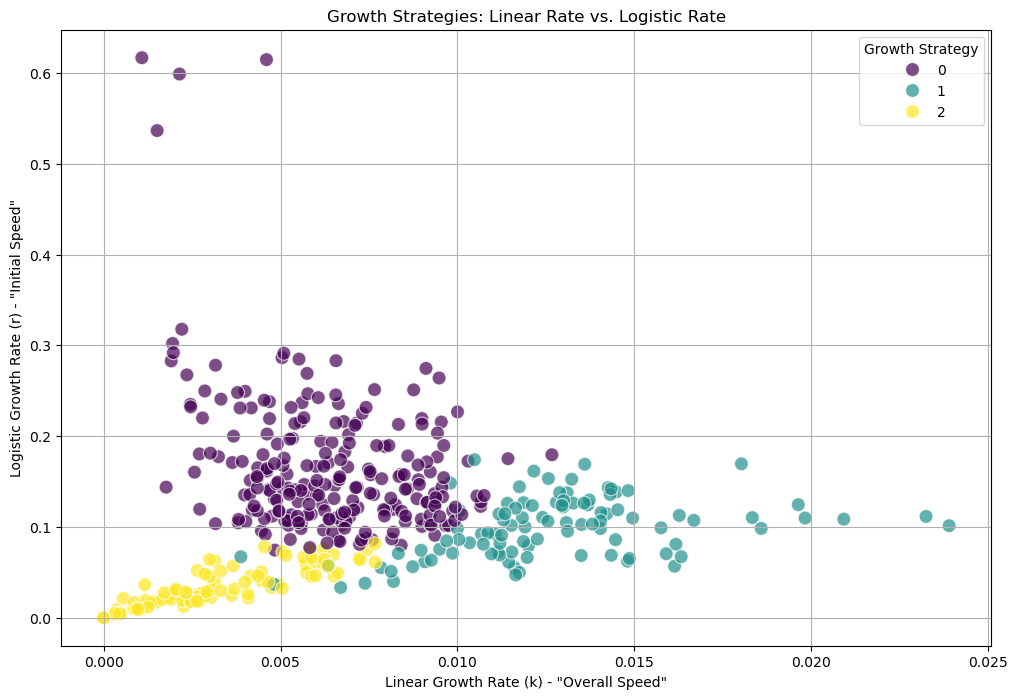

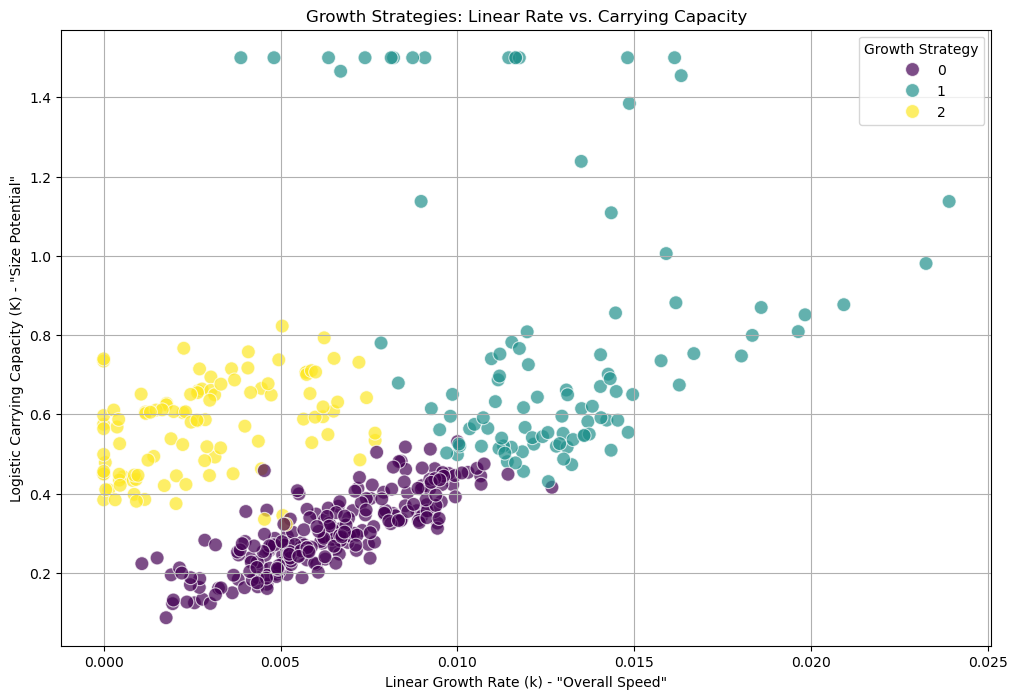

In [7]:
# --- Additional Cluster Visualizations ---

# This code assumes 'results_df' with the 'growth_cluster' column exists from the previous cells.

# --- Plot 1: Linear Growth Rate vs. Logistic Growth Rate ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=results_df,
    x='k_optimal_linear',  # Linear Growth Rate on X-axis
    y='r_optimal_log',     # Logistic Growth Rate on Y-axis
    hue='growth_cluster',
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title(f'Growth Strategies: Linear Rate vs. Logistic Rate')
plt.xlabel('Linear Growth Rate (k) - "Overall Speed"')
plt.ylabel('Logistic Growth Rate (r) - "Initial Speed"')
plt.legend(title='Growth Strategy')
plt.grid(True)
plt.show()


# --- Plot 2: Linear Growth Rate vs. Logistic Carrying Capacity ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=results_df,
    x='k_optimal_linear',  # Linear Growth Rate on X-axis
    y='K_optimal_log',     # Logistic Carrying Capacity on Y-axis
    hue='growth_cluster',
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title(f'Growth Strategies: Linear Rate vs. Carrying Capacity')
plt.xlabel('Linear Growth Rate (k) - "Overall Speed"')
plt.ylabel('Logistic Carrying Capacity (K) - "Size Potential"')
plt.legend(title='Growth Strategy')
plt.grid(True)
plt.show()

## Analyzing the Clusters
Now, let's analyze the average characteristics of each cluster to give them meaningful labels (e.g., "High Vigor," "Slow & Steady").

In [8]:
cluster_summary = results_df.groupby('growth_cluster')[features_for_clustering].mean()
print("--- Average Characteristics of Each Growth Strategy ---")
print(cluster_summary)

# You can also see which genotypes are most common in each cluster
print("\n--- Top 5 Genotypes in Each Cluster ---")
for i in range(OPTIMAL_K):
    print(f"\nCluster {i}:")
    # Get value counts, normalize to see percentage, and show top 5
    top_genotypes = results_df[results_df['growth_cluster'] == i]['Plant Genotype'].value_counts(normalize=True).head()
    print((top_genotypes * 100).round(1).astype(str) + '%')

--- Average Characteristics of Each Growth Strategy ---
                r_optimal_log  K_optimal_log  k_optimal_linear
growth_cluster                                                
0                    0.164793       0.303968          0.006405
1                    0.098645       0.793783          0.012631
2                    0.030621       0.567356          0.002891

--- Top 5 Genotypes in Each Cluster ---

Cluster 0:
Plant Genotype
BESC-284     3.4%
LILC-26-2    3.0%
BESC-1154    3.0%
CHWK-27-4    3.0%
BESC-44      3.0%
Name: proportion, dtype: object

Cluster 1:
Plant Genotype
BESC-856     6.9%
BESC-1108    5.9%
BESC-1068    5.9%
BESC-1025    5.9%
GW-9837      5.9%
Name: proportion, dtype: object

Cluster 2:
Plant Genotype
GW-9842      7.5%
BESC-1159    5.6%
BESC-1166    4.7%
BESC-56      4.7%
BESC-1096    4.7%
Name: proportion, dtype: object
